# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import random
from glob import glob
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
%matplotlib inline
# create a image generator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

In [3]:
  brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
brain_df.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [5]:
data_map = []
for sub_dir_path in glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [7]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_48.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_48_mask.tif


In [8]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
'''pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 50)'''
brain_df



,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif,0


# Phân loại

In [9]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [10]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [11]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [12]:
batch_size = 16
epochs = 100
image_size = 256

In [13]:
# split the data into train and test data
train, test = train_test_split(brain_df_train, test_size = 0.2)
# create a image generator
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
train_datagen  = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.3,
    rotation_range=20,            # Rotate images by 20 degrees
    width_shift_range=0.1,        # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,       # Randomly shift images vertically by 10% of the height
    zoom_range=0.2,               # Apply random zooming in the range of 0.8 to 1.2
    horizontal_flip=True         # Flip images horizontally
)
     

In [14]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=batch_size,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2201 validated image filenames belonging to 2 classes.
Found 942 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


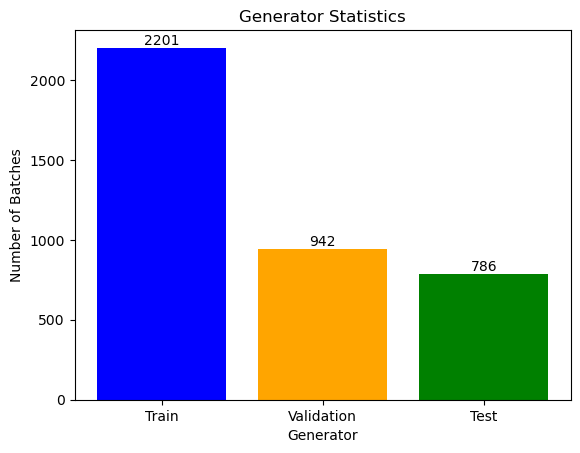

In [15]:
# Calculate the number of batches in each generator
train_steps = train_generator.n
valid_steps = valid_generator.n
test_steps = test_generator.n

# Create a list of labels for the x-axis
labels = ['Train', 'Validation', 'Test']

# Create a list of values for the y-axis
values = [train_steps, valid_steps, test_steps]

# Define the colors for each bar
colors = ['blue', 'orange', 'green']

# Plot the bar chart
plt.bar(labels, values, color=colors)
plt.xlabel('Generator')
plt.ylabel('Number of Batches')
plt.title('Generator Statistics')

# Add the numbers on top of the bars
for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()


# VGG19

In [17]:
# transfer learning
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

base_model  = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in base_model.layers:
    layer.trainable = False
# Thêm các layers phân loại mới
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_VGG19 = Model(inputs=base_model.input, outputs=predictions)

    
#display(tf.keras.utils.plot_model(model_VGG19, to_file='model_VGG19.png', show_shapes=True))
model_VGG19.compile(loss='categorical_crossentropy',optimizer =adam,metrics=['accuracy'])

# Model checkpoint

checkpoint_filepath_transfer_VVG19 = 'model_VGG19.hdf5'
mc = ModelCheckpoint(filepath = checkpoint_filepath_transfer_VVG19, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)




80134624/80134624 [==============================] - 0s 0us/step


In [18]:
model_VGG19.summary()

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 64, 64, 1

In [19]:
# Train VGG model
start_time = time.time()
history_VGG19 = model_VGG19.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=epochs,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator),
                    callbacks=[mc, es, reduce_lr])
end_time = time.time()
VGG19_time = end_time-start_time

Epoch 1/100

138/138 [==============================] - 80s 512ms/step - loss: 0.6132 - accuracy: 0.7338 - val_loss: 0.5350 - val_accuracy: 0.6635 - lr: 0.0010

Epoch 2/100

138/138 [==============================] - 51s 369ms/step - loss: 0.4931 - accuracy: 0.7692 - val_loss: 0.4640 - val_accuracy: 0.7527 - lr: 0.0010

Epoch 3/100

138/138 [==============================] - 50s 361ms/step - loss: 0.4453 - accuracy: 0.7865 - val_loss: 0.3998 - val_accuracy: 0.8079 - lr: 0.0010

Epoch 4/100

138/138 [==============================] - 50s 366ms/step - loss: 0.4221 - accuracy: 0.8005 - val_loss: 0.3667 - val_accuracy: 0.8291 - lr: 0.0010

Epoch 5/100

138/138 [==============================] - 49s 358ms/step - loss: 0.4007 - accuracy: 0.8046 - val_loss: 0.3591 - val_accuracy: 0.8238 - lr: 0.0010

Epoch 6/100

138/138 [==============================] - 50s 361ms/step - loss: 0.3933 - accuracy: 0.8160 - val_loss: 0.3643 - val_accuracy: 0.8238 - lr: 0.0010

Epoch 7/100

138/138 [============

In [20]:
history_VGG19.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [21]:
VGG19_time

6731.7814338207245

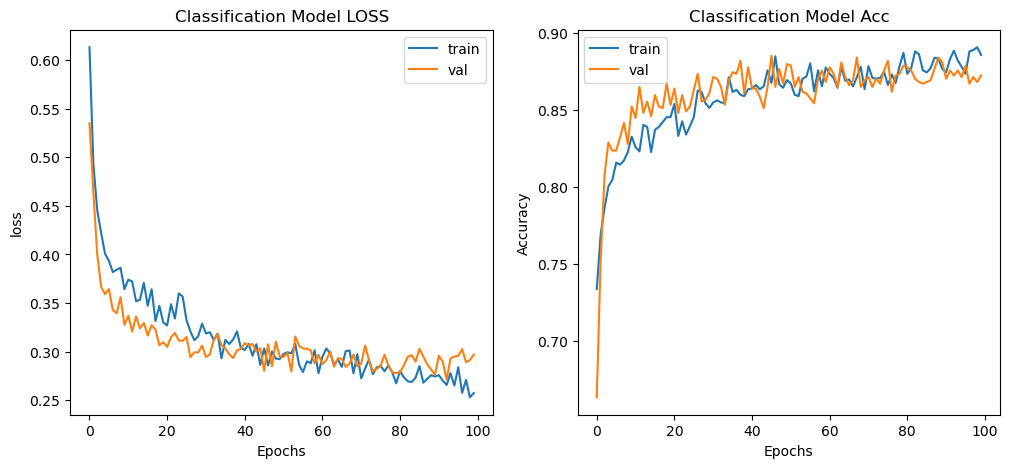

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_VGG19.history['loss']);
plt.plot(history_VGG19.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history_VGG19.history['accuracy']);
plt.plot(history_VGG19.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [23]:
loss_VGG19,acc_VGG19 = model_VGG19.evaluate(test_generator)
print("%s: %.4f" % ("Evaluate Test Loss", loss_VGG19))
print("%s: %.4f" % ("Evaluate Test accuracy", acc_VGG19))

50/50 [==============================] - 7s 134ms/step - loss: 0.2729 - accuracy: 0.8893

Evaluate Test Loss: 0.2729

Evaluate Test accuracy: 0.8893


1/1 [==============================] - 0s 484ms/step

Predictions: [[0.98675853 0.01324145]]

Độ chính xác: (98.676 %)

Dự đoán: Not Tumor

VGG19 Prediction


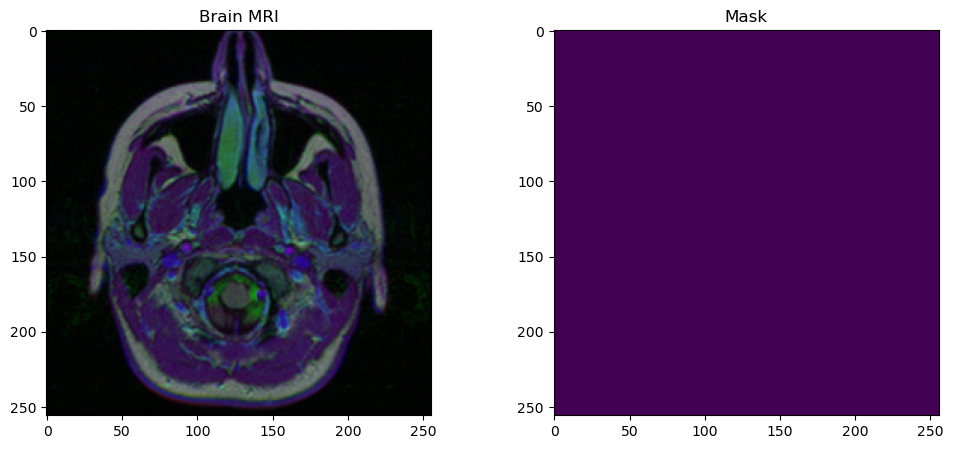


1/1 [==============================] - 0s 19ms/step

Predictions: [[0.5152545  0.48474547]]

Độ chính xác: (51.525 %)

Dự đoán: Not Tumor

VGG19 Prediction


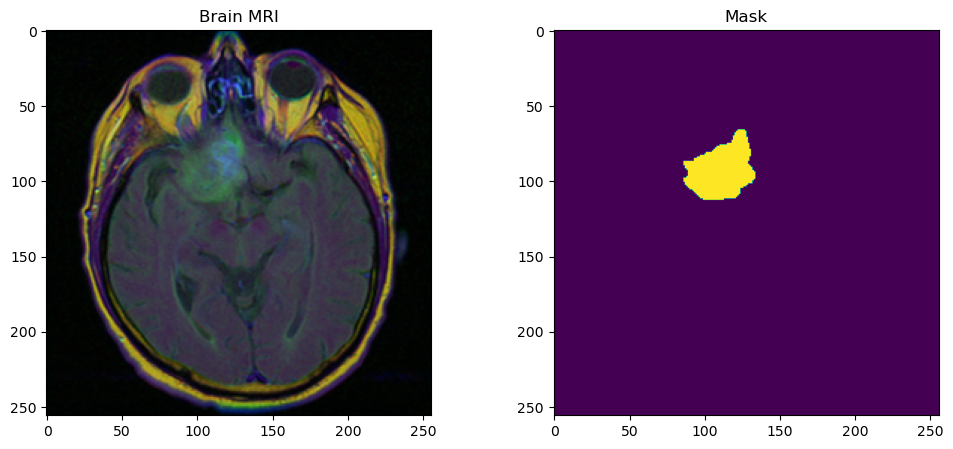

In [24]:
image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif')
image=cv2.resize(image,dsize=(256,256))
image=image /255.0
image_ex=np.expand_dims(image,axis=0)
image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif')

classes={0:'Not Tumor', 1:'Tumor'}
# Make prediction
prediction = model_VGG19.predict(image_ex)

decoded_predictions = [classes[i] for i in np.argmax(prediction, axis=1)]
titDudoan = decoded_predictions[0]
xacsuat = max(prediction[0])*100
# In kết quả
print('Predictions:', prediction)
print('Độ chính xác: ({:.3f} %)'.format(xacsuat))
print('Dự đoán: {}'.format(titDudoan))
print('VGG19 Prediction')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Brain MRI");
plt.subplot(1,2,2)
plt.imshow(image_mask)
plt.title("Mask");
plt.show()
print("===========================================================================================================")

image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif')
image=cv2.resize(image,dsize=(256,256))
image=image /255.0
image_ex=np.expand_dims(image,axis=0)
image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif')

classes={0:'Not Tumor', 1:'Tumor'}
# Make prediction
prediction = model_VGG19.predict(image_ex)

decoded_predictions = [classes[i] for i in np.argmax(prediction, axis=1)]
titDudoan = decoded_predictions[0]
xacsuat = max(prediction[0])*100
# In kết quả
print('Predictions:', prediction)
print('Độ chính xác: ({:.3f} %)'.format(xacsuat))
print('Dự đoán: {}'.format(titDudoan))
print('VGG19 Prediction')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Brain MRI");
plt.subplot(1,2,2)
plt.imshow(image_mask)
plt.title("Mask");
plt.show()

50/50 [==============================] - 3s 51ms/step
0.8893129770992366
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       520
           1       0.86      0.81      0.83       266

    accuracy                           0.89       786
   macro avg       0.88      0.87      0.87       786
weighted avg       0.89      0.89      0.89       786



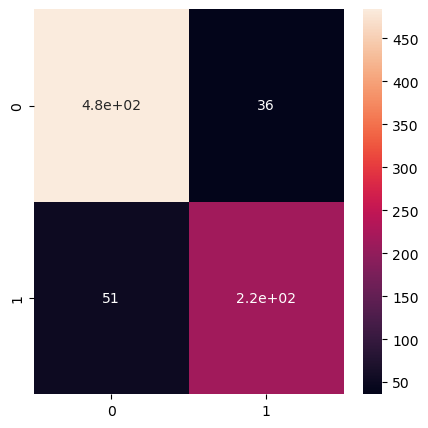

In [25]:
prediction = model_VGG19.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);